# Predicting anomalies in **critical infrastructure** with photonic fiber optic quantum sensing and QML

In the current notebook, we implement the QML module.


**_Core algorithm_** VQE

**_Problem definition_** Binary classifier: normal or anomaly

**_Dataset_** synthetic through randomized Hamiltonian

In [6]:
# Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.minimum_eigensolvers import vqe
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import Pauli, Operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

## Synthetic dataset creation

We create a randomized Hamiltonian that, if applied, models the presence of an anomaly in the infrastructure.

In [23]:
def str_to_list(string):
    '''
    Given a string input, it will output a list as each bit string as elements.
    '''
    new_list = []
    for i in string:
        new_list.append(int(i))
    return new_list


def hamiltonian_creation (num_qubits, w_0):
    '''
    Implementation of the w_O-parameterized Hamiltonian on a N-qubit system.
    '''
    
    # Initialize circuit and qubit states
    quantum_register = QuantumRegister(num_qubits, 'qubits')
    classical_register = ClassicalRegister(num_qubits, 'bits')
    circuit = QuantumCircuit(quantum_register, classical_register)
    circuit.h(quantum_register[0])
    circuit.cx(quantum_register[0], quantum_register[1:num_qubits])
    
    # Apply Hamiltonian to each qubit
    matrix = np.array([[1,0],[0, np.exp(-1j * w_0)]])
    operator = Operator(matrix)
    circuit.unitary(operator, quantum_register[0:num_qubits], label = 'U(w_0)')
    
    # Retrieve qubit states (for QML trained on quantum data) -> "quantum sensor"
    entangled_statevector = Statevector(circuit)
    
    # Measure qubits (for QML trained on classical data) -> "classical sensor"
    # circuit.cx(quantum_register[0], quantum_register[1:num_qubits])
    circuit.h(quantum_register[0:num_qubits])
    circuit.measure(quantum_register[0:num_qubits], classical_register[0:num_qubits])
    
    # Run jobs
    backend = AerSimulator(method = 'statevector', shots = 1)
    result = str_to_list(list(backend.run(circuit).result().get_counts().keys())[0])
    
    return circuit, entangled_statevector,result

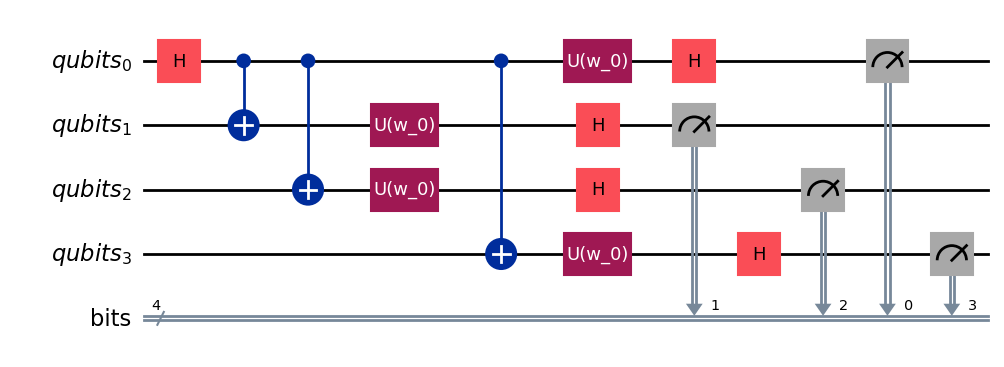

In [24]:
# Circuit example for 4 qubits
a = hamiltonian_creation(4, 0.2)
a[0].draw('mpl')

We now proceed to the dataset creation the generic implementation of the data preparation. Now, our particular model will consist on:
 
- The system shall be composed of 10 qubits.
- w_0 = 0 is assumed to be the normal state ("-1"). 
- w_0 ≠ 0 is assumed to be an anomaly ("1").

The synthethic data will consist of an imposed 50% "normal" states and 50% randomized w_0, that will be either anomaly or normal. Given that each w_0 is correlated to a quantum state, the QML model will infer the w_0 from the quantum state and thus generate the corresponding label.

In [27]:
# Particular model definition
row_count = 200
qubits_in_system = 10
normal_w_0 = 0
columns = ['quantum_state', 'q_0', 'q_1', 'q_2', 'q_3', 'q_4', 
           'q_5', 'q_6', 'q_7', 'q_8','q_9','label']
quantum_states = []
bits = [[]]
labels = []
new_rows = []

# Dataset creation
for i in range(row_count):
    if i < row_count / 2:  # Imposing 50% of normal instances
        circuit_result = hamiltonian_creation(qubits_in_system, normal_w_0)  # Each row correlates to a quantum circuit with a given Hamiltonian.
        new_row = [circuit_result[0]] + circuit_result[2] + [-1]  
    else:  # Randomising the other 50%.
        w_0_i = np.random.rand() * 2 * np.pi  # This could be done with a Quantum Random Number Generator also.
        circuit_result = hamiltonian_creation(qubits_in_system, w_0_i)
        
        if w_0_i == 0:  # Anomaly labelling
            new_row = [circuit_result[0]] + circuit_result[2] + [-1]
        else:
            new_row = [circuit_result[0]] + circuit_result[2] + [1]
            
    new_rows.append(new_row)
    
    
dataset = pd.DataFrame(new_rows, columns=columns)


In [28]:
# Dataset format
dataset.head()

,quantum_state,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,label
0,"((Instruction(name='h', num_qubits=1, num_clbi...",0,1,1,0,0,1,1,0,0,0,-1
1,"((Instruction(name='h', num_qubits=1, num_clbi...",1,1,1,1,1,1,0,0,1,1,-1
2,"((Instruction(name='h', num_qubits=1, num_clbi...",0,0,0,0,1,1,1,1,1,1,-1
3,"((Instruction(name='h', num_qubits=1, num_clbi...",1,0,0,0,0,0,1,0,0,0,-1
4,"((Instruction(name='h', num_qubits=1, num_clbi...",0,1,0,0,0,0,0,1,1,1,-1


## Variational Quantum Classifier trained on Classical Bits

In [37]:
# Train-test split
train, test = train_test_split(dataset, test_size=0.2)
classical_train = train.drop(columns = ['quantum_state'])
classical_test = test.drop(columns = ['quantum_state'])

X_classical_train = classical_train.drop(columns=['label']).values
Y_classical_train = classical_train['label'].values

X_classical_test = classical_test.drop(columns=['label']).values
Y_classical_test = classical_test['label'].values

In [38]:
# Classical dataset format
classical_train.head()

,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,label
50,1,1,0,0,1,0,0,0,0,1,-1
110,1,0,1,0,0,0,1,0,0,0,1
44,0,0,1,0,1,1,1,0,0,0,-1
118,0,1,0,1,1,1,0,0,1,0,1
78,0,1,0,0,0,1,1,0,1,0,-1


In [39]:
# Construct feature map, ansatz, and optimizer
num_inputs = classical_train.shape[0]
ansatz = RealAmplitudes(qubits_in_system, reps=3)

# Construct Variational Quantum Classifier
classical_vqc = VQC(
    num_qubits = qubits_in_system,
    ansatz = ansatz,
    loss = "cross_entropy",
    optimizer = COBYLA(maxiter = 30)
)

In [40]:
# Define a range of repetitions to experiment with
reps_range = [3]

# Empty list to store test scores for each value of reps
classical_test_scores = []

# Loop through each value of reps
for reps in reps_range:
    # Construct ansatz with current value of reps
    ansatz = RealAmplitudes(qubits_in_system, reps = reps)
    
    # Construct VQC with current ansatz
    classical_vqc = VQC(
        num_qubits = qubits_in_system,
        ansatz = ansatz,
        loss = "cross_entropy",
        optimizer = COBYLA(maxiter = 30)
    )
    
    # Fit classifier to data
    classical_vqc.fit(X_classical_train, Y_classical_train)
    
    # Score classifier on test data
    classical_test_score = classical_vqc.score(X_classical_test, Y_classical_test)
    
    # Append test score to the list
    classical_test_scores.append(classical_test_score)

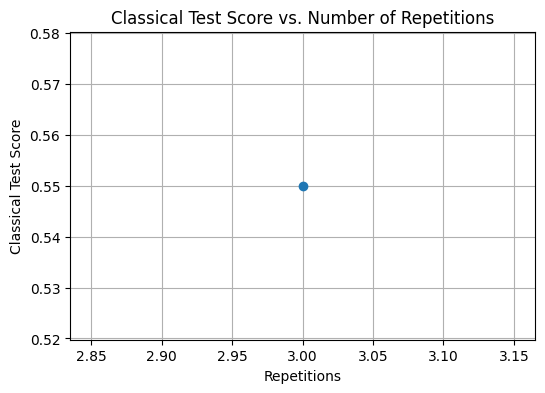

In [41]:
# Plot test scores against repetitions
plt.plot(reps_range, classical_test_scores, marker='o')
plt.xlabel('Repetitions')
plt.ylabel('Classical Test Score')
plt.title('Classical Test Score vs. Number of Repetitions')
plt.grid(True)
plt.show()

## Variational Quantum Classifier trained on Quantum States

In [ ]:
# Train-test split
train, test = train_test_split(dataset, test_size=0.2)
quantum_train = train['quantum_state']
quantum_test = test.drop(columns = ['quantum_state'])

X_quantum_train = quantum_train.drop(columns=['label']).values
Y_quantum_train = quantum_train['label'].values

X_quantum_test = quantum_test.drop(columns=['label']).values
Y_quantum_test = quantum_test['label'].values